<a href="https://colab.research.google.com/github/hail-members/distributed-deep-learning/blob/main/Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**기존 신경망 모델을 양자화**하여 모델 크기와 지연 시간을 줄이는 방법을 연습합니다. 목표는 다음과 같습니다.

- **양자화(Quantization)**의 기본 개념

1.   k-평균(k-means) 양자화의 구현 및 적용
  - **k-평균 양자화를 위한 양자화 인식 학습(Quantization-aware Training)**의 구현 및 적용

2.   선형 양자화(linear quantization)의 구현 및 적용
  - **선형 양자화를 위한 정수 기반 추론(Integer-only Inference)**의 구현 및 적용

3.   양자화의 성능 분석
  - 양자화를 통해 성능이 개선되는 예(예: 속도 향상)에 대한 기본적인 이해
  - 이러한 양자화 방법들의 차이점과 트레이드오프(trade-offs) 이해하기

Q & P 둘 다 적용하기?



## Basic setup

In [50]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [51]:
!pip install torchprofile
!pip install fvcore

In [52]:
import random
from collections import OrderedDict, defaultdict
import copy
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

assert torch.cuda.is_available(), \
"The current runtime does not have CUDA support." \
"Please go to menu bar (Runtime - Change runtime type) and select GPU"

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [53]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


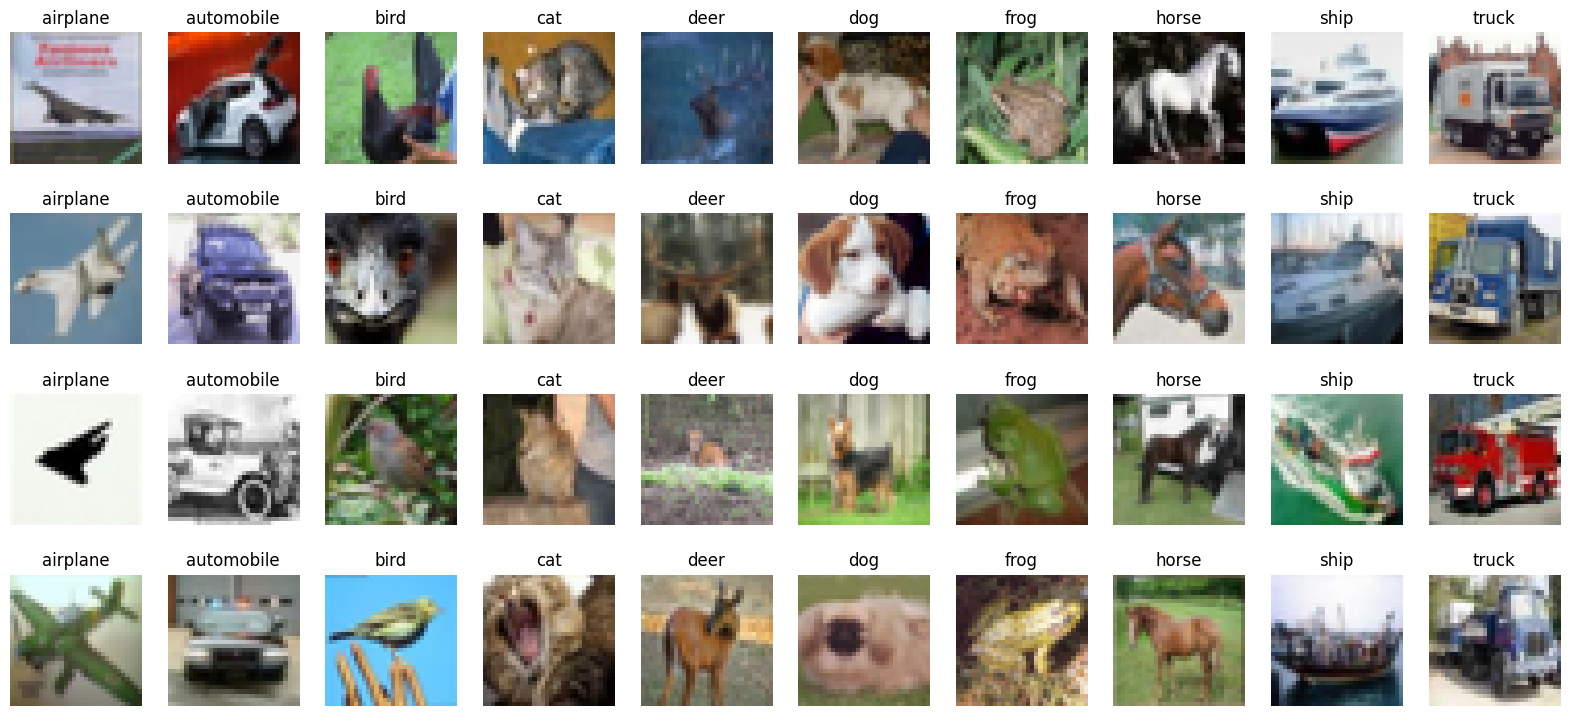

In [54]:
samples = [[] for _ in range(10)]
for image, label in dataset["test"]:
  if len(samples[label]) < 4:
    samples[label].append(image)

plt.figure(figsize=(20, 9))
for index in range(40):
  label = index % 10
  image = samples[label][index // 10]

  # Convert from CHW to HWC for visualization
  image = image.permute(1, 2, 0)

  # Convert from class index to class name
  label = dataset["test"].classes[label]

  # Visualize the image
  plt.subplot(4, 10, index + 1)
  plt.imshow(image)
  plt.title(label)
  plt.axis("off")
plt.show()

In [55]:
dataflow = {}
for split in ['train', 'test']:
  dataflow[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

In [56]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [57]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))
    add("avgpool", nn.AvgPool2d(2))
    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = x.view(x.shape[0], -1)

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x
checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

<ipython-input-57-b10c965b8d30>:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")


=> loading checkpoint 'https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


## 0. 여기서 부터

그리고 몇가지 모델의 efficiency metrics 와 관련된 - 측정할 때 쓸 코드들 만들어두기

evaluate / train 하는 코드 역시도 pruning 할때와 마찬가지로 만들어둬야합니다.

```
x = torch.tensor([1.], requires_grad=True)
with torch.no_grad():
    y = x * 2
y.requires_grad
>>> False

@torch.no_grad()
def doubler(x):
    return x * 2
z = doubler(x)
z.requires_grad
>>> False
```

In [58]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [59]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

Efficient metric 계산하는 파트는 다음과 같이 FLOPS 와 model size 를 계산하는 부분으로 구성합니다.

In [60]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [61]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [62]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

fp32 model has accuracy=92.95%
fp32 model has size=35.20 MiB


우리의 예제는 작은 모델이지만 큰 신경망 모델의 경우 더 거대할 수 있습니다. 특히 위와 같이 30MB 정도의 수준도 모바일 디바이스에서는 연산량을 많이 필요로 할 수 있습니다. 이에 따라서 우리는 parameter 수를 급격하게 줄일 수 있는 pruning 을 사용할 수 있습니다.

## 1. K-means Quantization

네트워크 양자화는 네트워크를 압축하여 딥 네트워크를 표현하는 데 필요한 가중치당 비트를 줄이는 방식입니다. 양자화된 네트워크는 하드웨어 지원을 통해 더 빠른 추론 속도를 가질 수 있습니다.

이 섹션에서는 [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf)에서 소개된 신경망을 위한 K-means 양자화를 살펴볼 것입니다.

$n$-비트 K-means 양자화는 시냅스를 $2^n$ 개의 클러스터로 나누고, 동일한 클러스터에 속하는 시냅스는 동일한 가중치 값을 공유합니다.

따라서 K-means 양자화는 다음을 포함하는 코드북(codebook)을 생성합니다:
*   `centroids`: $2^n$ 개의 fp32 클러스터 중심.
*   `labels`: 원래 fp32 가중치 텐서와 동일한 요소 수를 가지는 $n$-비트 정수 텐서. 각 정수는 해당 시냅스가 속한 클러스터를 나타냅니다.

추론 중에는, 추론을 위해 코드북을 기반으로 fp32 텐서가 생성됩니다:

> ***quantized_weight* = *codebook.centroids*\[*codebook.labels*\].view_as(weight)**


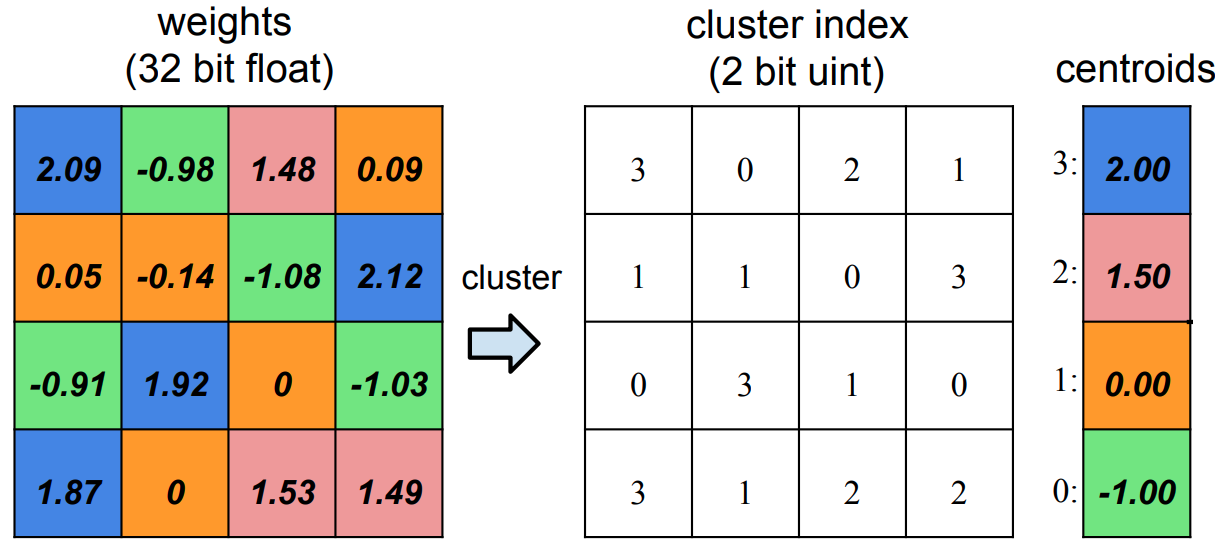

In [63]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [64]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()

    print(test_tensor)
    plot_matrix(test_tensor, ax_left, 'original tensor')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth) # 이 부분이 우리가 구현해야하는 부분
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Test k_means_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == min((1 << bitwidth), num_unique_values_before_quantization)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', cmap='tab20c')
    fig.tight_layout()
    plt.show()

In [65]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)
    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

In [66]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    Quantize tensor using k-means clustering.
    :param fp32_tensor: [torch.Tensor] Input tensor to be quantized.
    :param bitwidth: [int] Quantization bit width, default=4.
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor).
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] The cluster centroids.
            labels: [torch.(cuda.)LongTensor] Cluster label tensor.
    """
    if codebook is None:
        # Calculate the number of clusters based on the quantization bit width.
        n_clusters = 2 ** bitwidth  # 2^bitwidth clusters.

        # Perform k-means clustering to find centroids and assign labels to input tensor elements.
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)  # Cluster assignment for each element.
        centroids = kmeans.centroids.to(torch.float).view(-1)  # Cluster centroids.

        # Create a codebook containing centroids and labels.
        codebook = Codebook(centroids, labels)

    # Decode the codebook into a quantized tensor for inference.
    quantized_tensor = codebook.centroids[codebook.labels]  # Map labels to corresponding centroid values.

    # Update the input tensor with the quantized values, matching its original shape.
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))

    return codebook


tensor([[-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]])
* Test k_means_quantize()
    target bitwidth: 2 bits
        num unique values before k-means quantization: 25
        num unique values after  k-means quantization: 4
* Test passed.


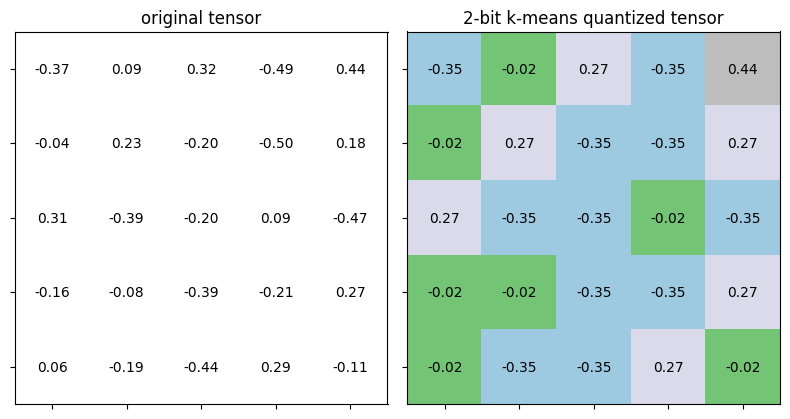

In [67]:
test_k_means_quantize()

## 모델 전체에 K-means Quantization 하는 방법

Lab 1에서 했던 것처럼, 이번에는 k-means 양자화 기능을 클래스 형태로 감싸서 전체 모델에 양자화를 적용합니다.  
`KMeansQuantizer` 클래스에서는 모델 가중치가 변경될 때마다 코드북(즉, centroids와 labels)을 적용하거나 업데이트할 수 있도록 코드북을 기록해야 합니다.


In [68]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

In [69]:
print('Note that the storage for codebooks is ignored when calculating the model size.')
quantizers = dict()
for bitwidth in [8, 4, 2]:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

Note that the storage for codebooks is ignored when calculating the model size.
k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=92.76%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    4-bit k-means quantized model has accuracy=79.07%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    2-bit k-means quantized model has accuracy=10.00%


## 학습된 K-Means 양자화

위에서 보인 결과에서 알 수 있듯이, 모델을 더 낮은 비트로 양자화하면 정확도가 크게 떨어집니다.  
따라서 정확도를 회복하기 위해 quantization-aware training, QAT를 해야 합니다. 이는 모델을 학습시킨 후 양자화하는 것이 아닌 학습중에 양자화를 쓰면서 그 양자화가 성능 저하가 되지 않도록 학습하는 방법입니다.

K-means QAT 동안에는 [Deep Compression: Compressing Deep Neural Networks With Pruning, Trained Quantization And Huffman Coding](https://arxiv.org/pdf/1510.00149.pdf)에서 제안된 대로 centroids도 업데이트됩니다.

centroids에 대한 gradient 계산은 다음과 같습니다.

> $\frac{\partial \mathcal{L} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \frac{\partial W_{j} }{\partial C_k} = \sum_{j} \frac{\partial \mathcal{L} }{\partial W_{j}} \mathbf{1}(I_{j}=k)$

여기서 $\mathcal{L}$은 손실(loss), $C_k$는 *k*-번째 centroid, $I_{j}$는 가중치 $W_{j}$의 레이블을 의미합니다.  
$\mathbf{1}()$는 지시 함수(indicator function)이며, $\mathbf{1}(I_{j}=k)$는 $I_{j}=k$일 경우 $1$을, 그렇지 않을 경우 $0$을 의미합니다. 즉, $I_{j}==k$를 나타냅니다.

예제에서는 **단순화를 위해**, 최신 가중치에 따라 centroids를 직접 업데이트합니다.

> $C_k = \frac{\sum_{j}W_{j}\mathbf{1}(I_{j}=k)}{\sum_{j}\mathbf{1}(I_{j}=k)}$

실제로는


In [70]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    Update the centroids in the codebook using updated fp32_tensor.
    :param fp32_tensor: [torch.(cuda.)Tensor] The updated full-precision tensor.
    :param codebook: [Codebook] Contains the cluster centroids and the cluster label tensor.
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        # Update each centroid based on the average of all weights assigned to the corresponding cluster.
        codebook.centroids[k] = fp32_tensor[codebook.labels == k].mean()


이제 다음 코드 셀을 실행하여 k-means 양자화된 모델을 미세 조정(finetune)하여 정확도를 회복해봅시다.  
정확도의 감소가 0.5 미만이면 미세 조정을 중단합니다.


In [71]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
    else:
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    8-bit k-means quantized model has accuracy=92.76% before quantization-aware training 
        No need for quantization-aware training since accuracy drop=0.19% is smaller than threshold=0.50%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    4-bit k-means quantized model has accuracy=79.07% before quantization-aware training 
        Quantization-aware training due to accuracy drop=13.88% is larger than threshold=0.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 0 Accuracy 92.47% / Best Accuracy: 92.47%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


eval:   0%|          | 0/20 [00:00<?, ?it/s]

    2-bit k-means quantized model has accuracy=10.00% before quantization-aware training 
        Quantization-aware training due to accuracy drop=82.95% is larger than threshold=0.50%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 0 Accuracy 90.21% / Best Accuracy: 90.21%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 1 Accuracy 90.82% / Best Accuracy: 90.82%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 2 Accuracy 91.00% / Best Accuracy: 91.00%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 3 Accuracy 91.13% / Best Accuracy: 91.13%


train:   0%|          | 0/98 [00:00<?, ?it/s]

eval:   0%|          | 0/20 [00:00<?, ?it/s]

        Epoch 4 Accuracy 91.19% / Best Accuracy: 91.19%


# 2. Linear Quantization

이 섹션에서는 **Linear Quantization**를 봅시다.

Linear Quantization는 범위 축소 및 스케일링 후, 부동소수점 값을 가장 가까운 양자화된 정수로 반올림하는 방식으로 수행됩니다.

[Linear Quantization](https://arxiv.org/pdf/1712.05877.pdf)는 다음과 같이 표현됩니다:

$r = S(q-Z)$

여기서 $r$은 부동소수점 실수, $q$는 *n*-비트 정수, $Z$는 *n*-비트 정수, $S$는 부동소수점 실수를 나타냅니다.  
$Z$는 양자화 zero point, $S$는 양자화 scaling factor입니다.  
상수 $Z$와 $S$는 모두 양자화 파라미터입니다.

기억나시죠?

## *n*-비트 정수

*n*-비트 부호 있는 정수는 일반적으로 [two's complement](https://en.wikipedia.org/wiki/Two%27s_complement) 표기법(2의 보수?법)으로 표현됩니다. 10진법에서 1의 보수는 8, 2의 보수는 7 이런식입니다. 이진법에서 보수는 0일때 1 1일때 0이 됩니다.

이렇게 0 또는 1로 가득 채운 숫자들로 표현되는 정수의 범위는 다음과 같습니다. *n*-비트 부호 있는 정수는 $[-2^{n-1}, 2^{n-1}-1]$ 범위의 정수를 나타낼 수 있습니다.  
예를 들어, 8비트 정수는 [-128, 127] 범위에 속합니다.




In [72]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

In [73]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


In [74]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    Linear quantization for a single floating-point tensor.
      From
        fp_tensor = (quantized_tensor - zero_point) * scale
      We derive,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param fp_tensor: [torch.(cuda.)FloatTensor] Floating-point tensor to be quantized.
    :param bitwidth: [int] Quantization bit width.
    :param scale: [torch.(cuda.)FloatTensor] Scaling factor.
    :param zero_point: [torch.(cuda.)IntTensor] Desired zero point of tensor values.
    :return:
        [torch.(cuda.)FloatTensor] Quantized tensor with integer values.
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    # Step 1: Scale the fp_tensor.
    scaled_tensor = fp_tensor / scale

    # Step 2: Round the floating-point values to integer values.
    rounded_tensor = scaled_tensor.round()

    rounded_tensor = rounded_tensor.to(dtype)

    # Step 3: Shift the rounded tensor to include the zero point.
    shifted_tensor = rounded_tensor + zero_point

    # Step 4: Clamp the shifted tensor to lie within the bitwidth-bit range.
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)

    return quantized_tensor


* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.3333333333333333
        zero point: -1
* Test passed.


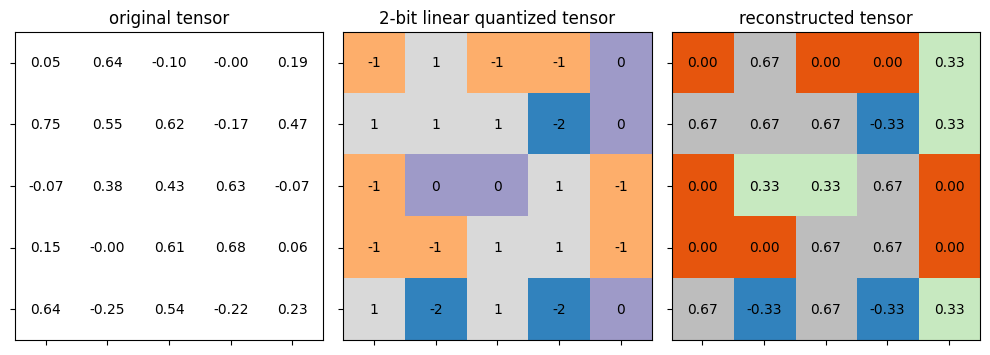

In [75]:
test_linear_quantize()

부동소수점 텐서 `fp_tensor`의 $r_{\mathrm{min}}$과 $r_{\mathrm{max}}$을 결정하는 데 여러 접근 방법이 있습니다.

* 가장 일반적인 방법은 `fp_tensor`의 최소값과 최대값을 직접 사용하는 것입니다. 이게 우리가 볼 예제구요
* 또 다른 널리 사용되는 방법은 Kullback-Leibler 발산(Kullback-Leibler divergence)을 최소화하여 *fp_max*를 결정하는 방법입니다. 다시말해 실제 분포를 제대로 반영할 수 있는 quantization *fp_max*를 결정해 활용하는 겁니다.



### 스케일 (Scale)

Linear Quantization 은 부동소수점 범위 [*fp_min*, *fp_max*]를 양자화 범위 [*quantized_min*, *quantized_max*]로 투영합니다. 즉, 다음을 의미합니다:

> $r_{\mathrm{max}} = S(q_{\mathrm{max}}-Z)$
>
> $r_{\mathrm{min}} = S(q_{\mathrm{min}}-Z)$

이 두 식을 빼면, 다음을 얻을 수 있습니다.


$$
r_{\mathrm{max}} - r_{\mathrm{min}} = S(q_{\mathrm{max}} - Z) - S(q_{\mathrm{min}} - Z)
$$

공통 항 $S$를 묶으면:

$$
r_{\mathrm{max}} - r_{\mathrm{min}} = S \left[ (q_{\mathrm{max}} - Z) - (q_{\mathrm{min}} - Z) \right]
$$

$$
r_{\mathrm{max}} - r_{\mathrm{min}} = S (q_{\mathrm{max}} - q_{\mathrm{min}})
$$


양변을 $(q_{\mathrm{max}} - q_{\mathrm{min}})$로 나누면:

$$
S = \frac{r_{\mathrm{max}} - r_{\mathrm{min}}}{q_{\mathrm{max}} - q_{\mathrm{min}}}
$$

따라서, 스케일($S$)은 부동소수점 범위의 차이를 양자화 범위의 차이로 나눈 값으로 정의됩니다.


### 영점(zero point)

이를 위해, scaling factor $S$를 결정한 후, $r_{\mathrm{min}}$과 $q_{\mathrm{min}}$ 사이의 관계를 사용하여 zero point $Z$를 계산할 수 있습니다.


$$
Z = \text{int}\left(\text{round}\left(\frac{r_{\mathrm{min}}}{S} - q_{\mathrm{min}}\right)\right)
$$


In [76]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    Get quantization scale for a single tensor.
    :param fp_tensor: [torch.(cuda.)Tensor] Floating tensor to be quantized.
    :param bitwidth: [int] Quantization bit width.
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    # Calculate the scale factor.
    scale = (fp_max - fp_min) / (quantized_max - quantized_min)

    # Calculate the zero point.
    zero_point = quantized_min - (fp_min / scale)

    # Clip the zero_point to fall in [quantized_min, quantized_max].
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else:  # Convert from float to int using round().
        zero_point = round(zero_point)

    return scale, int(zero_point)


이제 `linear_quantize()` 함수와 `get_quantization_scale_and_zero_point()` 함수를 하나의 함수로 통합합니다.


In [77]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    Linear quantization for feature tensor.
    :param fp_tensor: [torch.(cuda.)Tensor] Floating feature to be quantized.
    :param bitwidth: [int] Quantization bit width.
    :return:
        [torch.(cuda.)Tensor] Quantized tensor.
        [float] Scale tensor.
        [int] Zero point.
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

Weight tensor 에 대한 linear quantization 적용

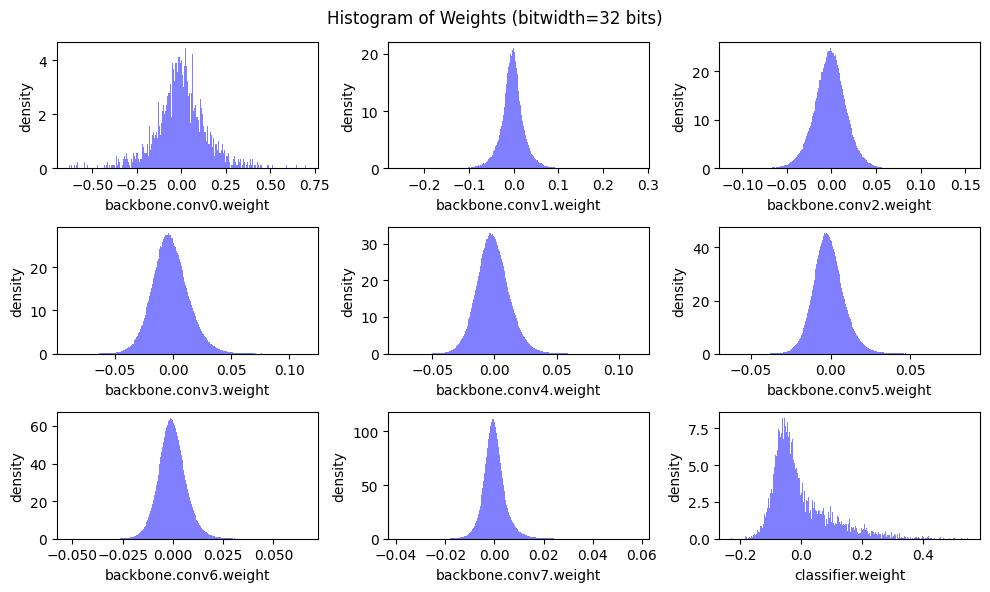

In [78]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)


위 히스토그램에서 볼 수 있듯이, 가중치 값의 분포는 (이 경우 분류기를 제외하고) 0을 기준으로 거의 대칭적입니다.  
따라서 가중치를 양자화할 때 영점 $Z$를 보통 $Z=0$으로 설정합니다.

$r = S(q-Z)$ 관계식에서:

> $r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

이 식을 사용하여:

> $S = \frac{r_{\mathrm{max}}}{q_{\mathrm{max}}}$

우리는 가중치 값의 최대 절대값을 $r_{\mathrm{max}}$로 직접 사용합니다.

In [79]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

### Per-channel Linear Quantization

2D 컨볼루션을 복습해 보면, 가중치 텐서는 `(num_output_channels, num_input_channels, kernel_height, kernel_width)` 형태의 4차원 텐서입니다.

다양한 실험 결과에 따르면, 서로 다른 출력 채널에 대해 각각 다른 스케일링 계수 $S$와 영점 $Z$를 사용하는 것이 성능에 더 좋습니다.  
따라서 각 출력 채널의 하위 텐서에 대해 독립적으로 스케일링 계수 $S$와 영점 $Z$를 결정해야 합니다.

$r = S(q-Z)$ 관계식에서:

> $r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

이 식을 사용하여:

> $S = \frac{r_{\mathrm{max}}}{q_{\mathrm{max}}}$

우리는 가중치 값의 최대 절대값을 $r_{\mathrm{max}}$로 직접 사용합니다.

In [80]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

### 서로 다른 bit-width 를 갖는 경우


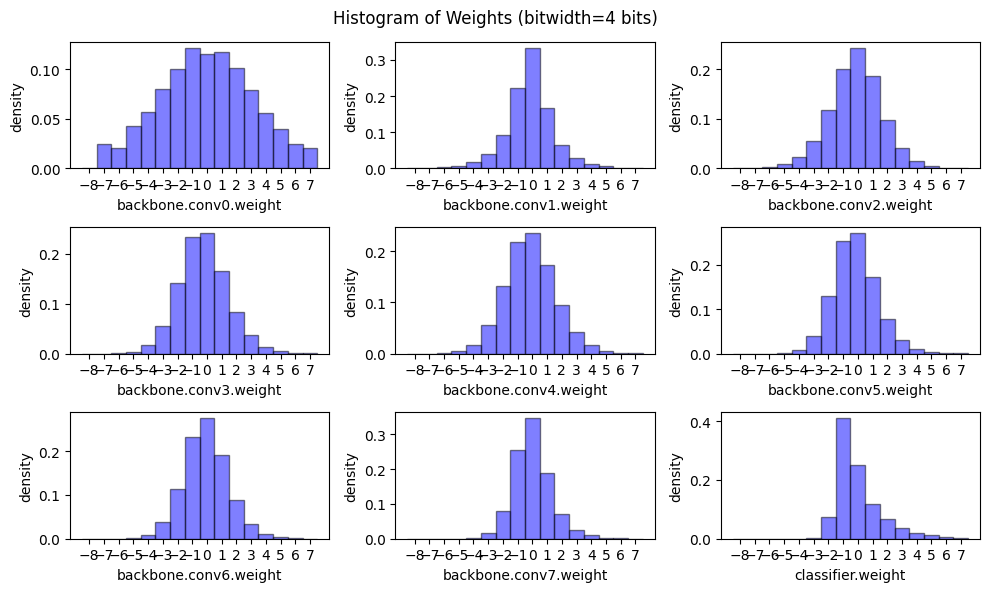

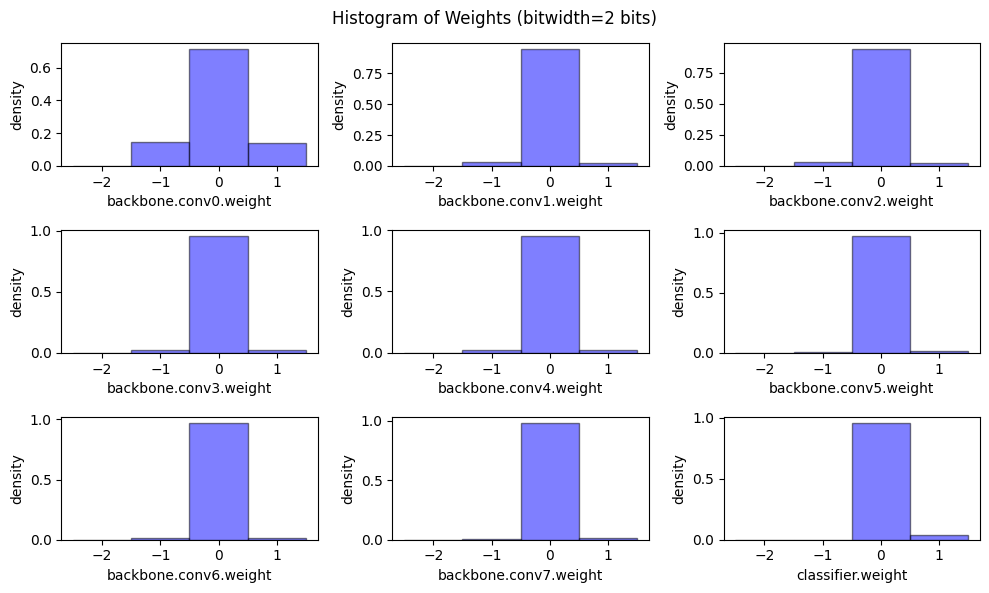

In [81]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

### Quantized inference


양자화 이후에는 컨볼루션 및 완전 연결 레이어의 추론 과정도 변경됩니다.


#### 컨볼루션 레이어의 경우

관계식 $r = S(q-Z)$를 복습하면:

> $r_{\mathrm{input}} = S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}})$  
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}(q_{\mathrm{weight}}-Z_{\mathrm{weight}})$  
> $r_{\mathrm{bias}} = S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$  

$Z_{\mathrm{weight}} = 0$이므로,  
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}q_{\mathrm{weight}}$

부동소수점 기반의 컨볼루션은 다음과 같이 작성됩니다:

> $r_{\mathrm{output}} = \mathrm{CONV}[r_{\mathrm{input}}, r_{\mathrm{weight}}] + r_{\mathrm{bias}}$  
> $\;\;\;\;\;\;\;\;= \mathrm{CONV}[S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}}), S_{\mathrm{weight}}q_{\mathrm{weight}}] + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$  
> $\;\;\;\;\;\;\;\;= \mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}]\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}}) + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

---

#### 계산 단순화를 위해

다음과 같은 조건을 설정합니다:

> $Z_{\mathrm{bias}} = 0$  
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

이 조건으로 $r_{\mathrm{output}}$를 다음과 같이 단순화할 수 있습니다:

> $r_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$  
> $\;\;\;\;\;\;\;\;= (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$

---

#### 양자화 출력 계산

$r_{\mathrm{output}} = S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}})$ 관계를 사용하면:

> $S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}}) = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$

정리하면:

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot \frac{S_{\mathrm{input}} \cdot S_{\mathrm{weight}}}{S_{\mathrm{output}}} + Z_{\mathrm{output}}$

여기서:

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

---

#### 완전 연결 레이어의 경우

비슷한 과정으로 완전 연결 레이어는 다음과 같이 계산됩니다:

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot \frac{S_{\mathrm{input}} \cdot S_{\mathrm{weight}}}{S_{\mathrm{output}}} + Z_{\mathrm{output}}$

여기서:

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

위로부터 우리는면

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

라는걸 알고있으므로 이를 반영하여 만들면

In [82]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    Linear quantization for a single bias tensor.
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] Bias weight to be quantized.
    :param weight_scale: [float or torch.FloatTensor] Weight scale tensor.
    :param input_scale: [float] Input scale.
    :return:
        [torch.IntTensor] Quantized bias tensor.
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    # Calculate the scale for the bias.
    bias_scale = weight_scale * input_scale

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

In [83]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

라는 걸 이용해서 quantized_linear 를 완성하면

In [84]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    Quantized fully-connected layer.
    :param input: [torch.CharTensor] Quantized input (torch.int8).
    :param weight: [torch.CharTensor] Quantized weight (torch.int8).
    :param bias: [torch.IntTensor] Shifted quantized bias or None (torch.int32).
    :param feature_bitwidth: [int] Quantization bit width of input and output.
    :param weight_bitwidth: [int] Quantization bit width of weight.
    :param input_zero_point: [int] Input zero point.
    :param output_zero_point: [int] Output zero point.
    :param input_scale: [float] Input feature scale.
    :param weight_scale: [torch.FloatTensor] Weight per-channel scale.
    :param output_scale: [float] Output feature scale.
    :return:
        [torch.CharIntTensor] Quantized output feature (torch.int8).
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: Integer-based fully-connected (8-bit multiplication with 32-bit accumulation).
    if 'cpu' in input.device.type:
        # Use 32-bit MAC for simplicity.
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # Current version of PyTorch does not yet support integer-based linear() on GPUs.
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())

    # Step 2: Scale the output.
    # Multiply by input and weight scales, then divide by the output scale.
    output = (output.float() * (input_scale * weight_scale.view(1, -1)) / output_scale)

    # Step 3: Shift output by output_zero_point.
    output = output + output_zero_point

    # Ensure all values lie within the bitwidth-bit range.
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output


* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 4
      input channels: 8
      output channels: 8
* Test passed.


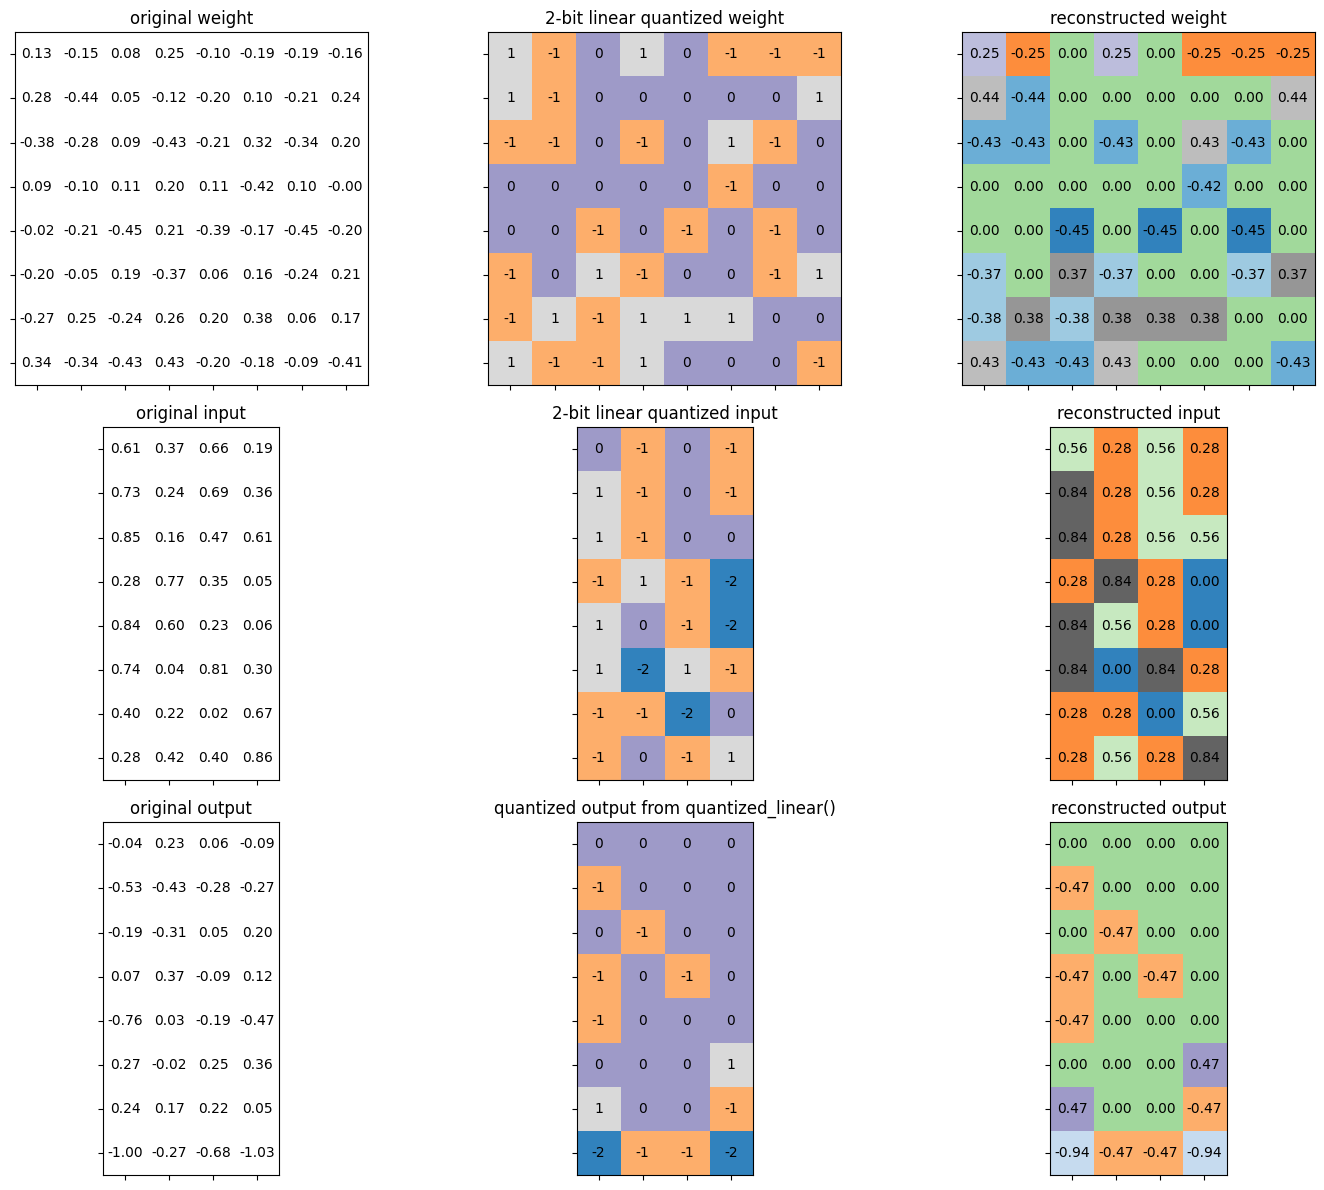

In [85]:
test_quantized_fc()

### Quantized Convolution



$Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.

bias 를 먼저

In [86]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$



In [87]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    Quantized 2D convolution.
    :param input: [torch.CharTensor] Quantized input (torch.int8).
    :param weight: [torch.CharTensor] Quantized weight (torch.int8).
    :param bias: [torch.IntTensor] Shifted quantized bias or None (torch.int32).
    :param feature_bitwidth: [int] Quantization bit width of input and output.
    :param weight_bitwidth: [int] Quantization bit width of weight.
    :param input_zero_point: [int] Input zero point.
    :param output_zero_point: [int] Output zero point.
    :param input_scale: [float] Input feature scale.
    :param weight_scale: [torch.FloatTensor] Weight per-channel scale.
    :param output_scale: [float] Output feature scale.
    :return:
        [torch.(cuda.)CharTensor] Quantized output feature.
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: Integer-based 2D convolution (8-bit multiplication with 32-bit accumulation).
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # Use 32-bit MAC for simplicity.
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # Current version of PyTorch does not yet support integer-based conv2d() on GPUs.
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    # Step 2: Scale the output.
    # Multiply by input and weight scales, then divide by the output scale.
    output = (output.float() * (input_scale * weight_scale.view(1, -1, 1, 1)) / output_scale)

    # Step 3: Shift output by output_zero_point.
    output = output + output_zero_point

    # Ensure all values lie within the bitwidth-bit range.
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output


# 3. 성능 평가

최종적으로 다음과 같은 단계를 거쳐서 quantize 를 하게 됩니다.

모든 과정을 종합하여 모델에 대해 `int8` 양자화를 수행합니다.  
모델의 컨볼루션 레이어와 완전 연결 레이어를 하나씩 양자화된 버전으로 변환할 것입니다.

---

### 1. BatchNorm과 Convolution 레이어 병합

먼저, BatchNorm 레이어를 이전 컨볼루션 레이어와 병합(fuse)합니다. 이는 양자화 전의 표준적인 과정입니다.  
BatchNorm 병합은 추론 중 추가적인 곱셈 연산을 줄입니다.

병합된 모델 `model_fused`가 원본 모델과 동일한 정확도를 가지는지 확인합니다  


In [88]:
def fuse_conv_bn(conv, bn):
    # https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html 참고하여 수정된 코드.
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))

# BatchNorm을 Conv 레이어에 병합
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))

# 확인: BatchNorm 레이어가 없어졌는지 확인
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

# 병합 후 정확도 확인: 정확도는 동일하게 유지됨
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')


Before conv-bn fusion: backbone length 29
After conv-bn fusion: backbone length 21


eval:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of the fused model=92.95%


### 2. 피처 맵 범위 계산

모델을 샘플 데이터로 실행하여 각 피처 맵의 범위를 기록합니다.
이 데이터를 사용해 피처 맵의 범위 및 해당 스케일링 계수와 영점을 계산할 수 있습니다.

In [89]:
# 활성화 값의 최소/최대 값을 기록하기 위한 hook 추가
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# hook 제거
for h in hooks:
    h.remove()


### 3. 모델 양자화

모델을 다음 매핑에 따라 양자화합니다:

```python
nn.Conv2d: QuantizedConv2d,
nn.Linear: QuantizedLinear,
# 아래 두 개는 단순히 래퍼(wrapper)로, 현재 torch 모듈이
# int8 데이터 형식을 지원하지 않기 때문에
# 계산 중 임시로 fp32로 변환하여 사용합니다.
nn.MaxPool2d: QuantizedMaxPool2d,
nn.AvgPool2d: QuantizedAvgPool2d,
```

In [90]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)

# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)

        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                        input_zero_point)

        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                input_zero_point)

quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

In [92]:
print(quantized_model)

def extra_preprocess(x):
    # Convert the original fp32 input (range: 0 to 1) into int8 format (range: -128 to 127)
    input_scale = 255 / (1 - 0)  # Scale factor for (0, 1) to (-128, 127)
    zero_point = -128  # Zero point for int8 range
    return (x * input_scale + zero_point).round().clamp(-128, 127).to(torch.int8)

int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")


VGG(
  (backbone): Sequential(
    (0): QuantizedConv2d()
    (1): QuantizedConv2d()
    (2): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): QuantizedConv2d()
    (4): QuantizedConv2d()
    (5): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): QuantizedConv2d()
    (7): QuantizedConv2d()
    (8): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): QuantizedConv2d()
    (10): QuantizedConv2d()
    (11): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): QuantizedAvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): QuantizedLinear()
)


eval:   0%|          | 0/20 [00:00<?, ?it/s]

int8 model has accuracy=92.90%


### 질문:  
왜 선형 양자화된 모델에는 ReLU 레이어가 없나?

### 답:  
선형 양자화에서는 활성화 값이 `int8` 범위로 제한되므로, ReLU와 같은 비선형 활성화 함수가 불필요합니다.  
ReLU는 음수를 제거하고 0 이상의 값을 통과시키는 역할을 하지만, 양자화된 값은 이미 정수형 범위 내에 제한되어 있어, 이러한 추가적인 연산이 없어도 동일한 효과를 얻을 수 있습니다.  
따라서 ReLU를 제거하면 모델의 계산량이 감소하고 추론 속도가 향상됩니다.

---

### 질문:  
k-means 기반 양자화와 선형 양자화의 장단점?

### 답:
#### k-means 기반 양자화  
**장점**:  
- 가중치의 분포를 더 잘 반영할 수 있어, 특정 데이터 분포에 대해 높은 정확도를 유지할 가능성
- 데이터 분포에 따라 더 적합한 클러스터링 결과

**단점**:  
- 양자화 과정에서 추가적인 클러스터링 연산이 필요하므로, 초기 모델 변환 과정에서 계산량이 많다.  
- 하드웨어 지원이 제한적이며, 일반적인 `int8` 연산에 비해 비효율적
- 추론 시 클러스터 중심값을 검색해야 하므로 지연 시간이 증가

#### 선형 양자화  
**장점**:  
- 단순한 선형 변환을 기반으로 하므로 계산량이 적고 빠르게 수행
- 대부분의 하드웨어에서 효율적으로 실행되며, `int8` 연산을 위한 강력한 지원
- 모델 크기와 추론 지연 시간을 크게 줄인다

**단점**:  
- 가중치 및 활성화 값의 분포를 균등하게 압축하므로, 데이터가 비대칭적으로 분포된 경우 정확도가 감소
- 특정 데이터 분포에 대한 유연성이 부족
